In [9]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [10]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [11]:
class QNetwork(nn.Module):
    """Modelo da Rede Q (Ator/Política)."""

    def __init__(self, state_size, action_size, seed):
        """Inicializa parâmetros e constrói o modelo.
        Params
        ======
            state_size (int): Dimensão do espaço de estados
            action_size (int): Dimensão do espaço de ações
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Constrói uma rede que mapeia estado -> valores de ação."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [12]:
BUFFER_SIZE = int(1e5)  # tamanho do buffer de repetição
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # fator de desconto
TAU = 1e-3              # parâmetro de suavização para atualização de rede
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # quantas etapas para atualizar a rede

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class Agent():
    """Interage e aprende com o ambiente."""

    def __init__(self, state_size, action_size, seed):
         """Inicializa um objeto Agente.
        
        Parâmetros
        ==========
            state_size (int): dimensão do espaço de estados
            action_size (int): dimensão do espaço de ações
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Networks
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Memória de repetição
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Inicializa o passo de tempo (para atualizar a cada UPDATE_EVERY etapas)
        self.t_step = 0

    def step(self, state, action, reward, next_state, next_action, done):
        # Save experience in replay memory
        # Armazena a experiência, tupla (S, A, R, S', A', D) na memória de repetição
        self.memory.add(state, action, reward, next_state, next_action, done)
        
        # Aprende a cada UPDATE_EVERY passos de tempo.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # Se há memória suficiente para amostragem, obtém um subconjunto aleatório e aprende
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)


    def act(self, state, eps=0.):
        """Retorna ações para um dado estado conforme a política atual.
        
        Parâmetros
        ==========
            state (array_like): estado atual
            eps (float): parâmetro de epsilon para a política epsilon-greedy
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Seleção de ação epsilon-greedy
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Atualiza os parâmetros de valor usando um lote de tuplas de experiência.

        Parâmetros
        ==========
            experiences (Tuple[torch.Tensor]): tupla de tuplas (s, a, r, s', a', done) 
            gamma (float): fator de desconto
        """
        
        # Obtém um minibatch aleatório de tuplas de D
        states, actions, rewards, next_states, next_actions, dones = experiences

        ## Calcula e minimiza a perda
        ### Extrai o próximo valor estimado máximo para a ação escolhida da rede-alvo
        q_targets_next = self.qnetwork_target(next_states).gather(1, next_actions)
        ### Calcula o valor alvo a partir da equação SARSA
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calcula o valor esperado para a ação escolhida da network local
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Calcula a perda (usa o erro quadrático médio)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Atualiza a rede-alvo, copiando todos os pesos e parâmetros da rede local
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)              

    def soft_update(self, local_model, target_model, tau):
        """Atualização suave dos parâmetros do modelo.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Parâmetros
        ==========
            local_model (PyTorch model): Pesos serão copiados a partir
            target_model (PyTorch model): Pesos serão copiados para
            tau (float): parâmetro de suavização
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [15]:
class ReplayBuffer:
    """Buffer de tamanho fixo para armazenar tuplas de experiência."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Inicializa um objeto ReplayBuffer.

        Parâmetros
        ==========
            action_size (int): dimensão de cada ação
            buffer_size (int): tamanho do buffer de repetição
            batch_size (int): tamanho do lote de amostras
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "next_action", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, next_action, done):
        """Add uma nova experiência à memória."""
        e = self.experience(state, action, reward, next_state, next_action, done)
        self.memory.append(e)
    
    def sample(self):
        """Amostra aleatoriamente um lote de experiências da memória."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        next_actions = torch.from_numpy(np.vstack([e.next_action for e in experiences if e is not None])).long().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, next_actions, dones)

    def __len__(self):
        """Retorna o tamanho atual da memória interna."""
        return len(self.memory)


In [16]:
def deep_sarsa(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep SARSA.

    Parâmetros
    ======
        n_episodes (int): número máximo de episódios de treinamento
        max_t (int): número máximo de etapas por episódio
        eps_start (float): valor inicial de epsilon, para seleção de ação epsilon-greedy
        eps_end (float): valor mínimo de epsilon
        eps_decay (float): fator multiplicativo (por episódio) para diminuir o epsilon
    """
    scores = []                        # lista contendo scores de cada episódio
    scores_window = deque(maxlen=100)  # últimos 100 scores
    eps = eps_start                    # inicializa epsilon

    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0
        action = agent.act(state, eps)

        for t in range(max_t):
            next_state, reward, done, _, _ = env.step(action)

            # Escolhe a próxima ação usando a política atual
            next_action = agent.act(next_state, eps)

            # Dá um passo e aprende com o algoritmo SARSA
            agent.step(state, action, reward, next_state, next_action, done)

            state = next_state
            action = next_action
            score += reward

            if done:
                break

        scores_window.append(score)  # salva o resultado mais recente
        scores.append(score)  
        eps = max(eps_end, eps_decay * eps)  # diminui epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                            np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_sarsa.pth')
            break

    return scores

# Reinicializa o agente para garantir que ele comece do zero
agent = Agent(state_size=8, action_size=4, seed=0)

# Executa o treinamento do Deep SARSA
scores_sarsa = deep_sarsa()

Episode 100	Average Score: -174.38
Episode 200	Average Score: -114.74
Episode 300	Average Score: -45.703
Episode 400	Average Score: -49.89
Episode 500	Average Score: 46.519
Episode 600	Average Score: 83.44
Episode 700	Average Score: 114.90
Episode 800	Average Score: 142.23
Episode 900	Average Score: 162.74
Episode 973	Average Score: 201.72
Environment solved in 873 episodes!	Average Score: 201.72


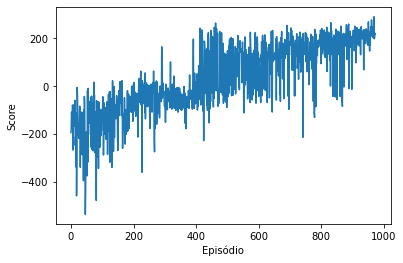

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_sarsa)), scores_sarsa)
plt.ylabel('Score')
plt.xlabel('Episódio')
plt.show()

In [22]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name, arch_name):
    env = gym.make(env_name, render_mode="rgb_array")
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(arch_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint_sarsa.pth'))
    i=0
    while i<15:    
        state, _ = env.reset()
        done = False
        truncated = False
        while not done and not truncated:
            if i>10:
                frame = env.render()
                vid.capture_frame()
            action = agent.act(state)
            state, reward, done, truncated, _ = env.step(action)
        i+=1
    env.close()


In [23]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2', 'sarsa')

/home/vanessa_wille/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video video/sarsa.mp4.
Moviepy - Writing video video/sarsa.mp4



Moviepy - Done !
Moviepy - video ready video/sarsa.mp4


In [24]:
show_video('sarsa')

: 